In [1]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from itertools import product

In [2]:
from arch import arch_model

In [3]:
with open('config.json') as file:
    config = json.load(file)

In [4]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']

# Main input data

In [5]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [6]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

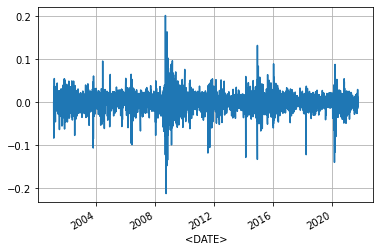

In [7]:
rtsi['log return'].plot()

plt.grid()
plt.show()

## Start date

In [8]:
rescale_factor = 100
start_date = '2014-01-01'

input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

In [9]:
n = input_data.shape[0]

In [10]:
n

1964

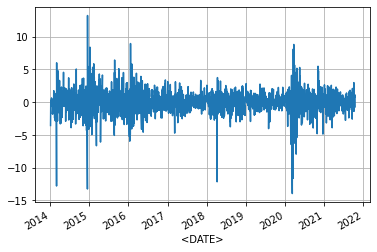

In [11]:
input_data.plot()

plt.grid()
plt.show()

In [12]:
input_data.describe()

count    1964.000000
mean        0.013812
std         1.826568
min       -13.948614
25%        -0.899103
50%         0.071543
75%         0.935148
max        13.246192
Name: log return, dtype: float64

In [13]:
days_of_week = pd.Series(input_data.index.dayofweek, index=input_data.index, name='day of week').copy()

## train & test split 

In [14]:
input_data.shape

(1964,)

In [221]:
n_train = 504  # 2000

n_test = 63
n_test = min(n - n_train, n_test)

In [222]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

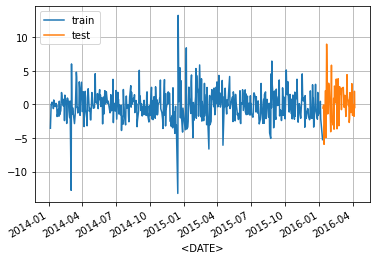

In [223]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [224]:
train.describe()

count    504.000000
mean      -0.143663
std        2.307118
min      -13.254545
25%       -1.542717
50%       -0.200937
75%        1.075399
max       13.246192
Name: log return, dtype: float64

# Consequent

In [225]:
# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

In [226]:
train_sample_std

2.3071180000948344

In [227]:
first_h

array([5.32279347])

## Using classic GARCH to get initial parameters values

In [228]:
garch_mean = 'Zero'
garch_dist = 'normal'

garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 308208503.12482625
Iteration:      2,   Func. Count:     11,   Neg. LLF: 1265.9261604539329
Iteration:      3,   Func. Count:     17,   Neg. LLF: 1098.1509698582563
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1097.1138414148031
Iteration:      5,   Func. Count:     27,   Neg. LLF: 1097.1137753058615
Iteration:      6,   Func. Count:     31,   Neg. LLF: 1097.1137744111038
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1097.1137744111038
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 6


In [229]:
garch_fitted.params

omega       0.544427
alpha[1]    0.113062
beta[1]     0.779222
Name: params, dtype: float64

In [230]:
alpha_0_ini_vanilla = garch_fitted.params.iloc[0]
alpha_ini_vanilla = garch_fitted.params.iloc[1:(q + 1)].values
beta_ini_vanilla = garch_fitted.params.iloc[(q + 1):].values

In [231]:
consequent_params_ini_vanilla = \
    {'alpha_0': alpha_0_ini_vanilla, 'alpha': alpha_ini_vanilla, 'beta': beta_ini_vanilla}

## Setting dict w/ all consequent meta parameters

In [232]:
consequent_metaparams = {'p': p, 'q': q, 'first_h': first_h}

##### `parameters_ini` and `bounds` not yet set!

## setting `parameters_ini` in consequent

In [233]:
# alpha_0_ini = np.array([alpha_0_ini_vanilla] * n_clusters)
# alpha_ini = np.array([alpha_ini_vanilla] * n_clusters).T
# beta_ini = np.array([beta_ini_vanilla] * n_clusters).T

consequent_params_ini = {'alpha_0': alpha_0_ini_vanilla,
                         'alpha': alpha_ini_vanilla,
                         'beta': beta_ini_vanilla}

consequent_metaparams['parameters_ini'] = consequent_params_ini

In [234]:
consequent_params_ini

{'alpha_0': 0.5444266632851174,
 'alpha': array([0.11306164]),
 'beta': array([0.7792224])}

## Setting consequent parameters constraints (passed to LS)

In [235]:
# lower_bounds = [0] * ((1 + p + q) * n_clusters)
# upper_bounds = [+np.inf] * n_clusters + [1] * ((p + q) * n_clusters)
# bounds = (lower_bounds, upper_bounds)

lower_bounds = [0] * ((1 + p + q))
upper_bounds = [+np.inf] + [1] * ((p + q))
bounds = (lower_bounds, upper_bounds)

consequent_metaparams['bounds'] = bounds

# Antecedent params

In [236]:
# file_name = '2022-02-01_06-25.json'
# with open(f'{antecedent_params_folder}/{file_name}', 'r') as file:
#     antecedent_params_set = json.load(file)

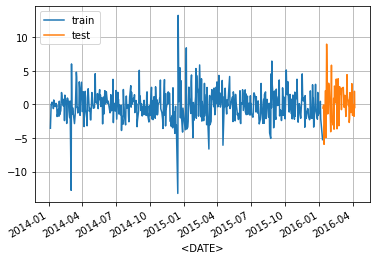

In [237]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [238]:
summary = pd.read_pickle(f'{research_results_folder}/summary_table.pkl')

In [239]:
summary.loc[18:2936, 'Vanilla GARCH MSE (w/ retraining)'] = 12.754186214433627

In [240]:
summary['Vanilla GARCH MSE n/r / model MSE'] = summary['Vanilla GARCH MSE (no retraining)'] / summary['MSE']
summary['Vanilla GARCH MSE w/r / model MSE'] = summary['Vanilla GARCH MSE (w/ retraining)'] / summary['MSE']

In [241]:
(summary['Vanilla GARCH MSE w/r / model MSE'] == summary['Vanilla GARCH MSE w/r / model MSE'].max()).sum()

81

In [242]:
summary.sort_values(by='Vanilla GARCH MSE w/r / model MSE', ascending=False).head(20)

,Time,p,q,Start date,Train size,Test size,# clusters,Centers,Variances,MSE,Vanilla GARCH MSE (no retraining),Vanilla GARCH MSE (w/ retraining),Vanilla GARCH MSE n/r / model MSE,Vanilla GARCH MSE w/r / model MSE
2448,2022-02-12 04-21-04,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[12, 6, 3, 4]",9.662553,17.889309,12.754186,1.851406,1.31996
2451,2022-02-12 04-21-04,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[12, 6, 3, 10]",9.662553,17.889309,12.754186,1.851406,1.31996
2449,2022-02-12 04-21-04,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[12, 6, 3, 9]",9.662553,17.889309,12.754186,1.851406,1.31996
2447,2022-02-12 04-21-04,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[12, 6, 3, 8]",9.662553,17.889309,12.754186,1.851406,1.31996
1150,2022-02-10 00-57-56,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[7, 6, 3, 5]",9.662553,17.889309,12.754186,1.851406,1.31996
2624,2022-02-12 05-07-43,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[5, 6, 3, 2]",9.662553,17.889309,12.754186,1.851406,1.31996
2816,2022-02-12 05-18-09,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[12, 6, 3, 6]",9.662553,17.889309,12.754186,1.851406,1.31996
2817,2022-02-12 05-18-09,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[12, 6, 3, 7]",9.662553,17.889309,12.754186,1.851406,1.31996
2818,2022-02-12 05-18-09,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[12, 6, 3, 5]",9.662553,17.889309,12.754186,1.851406,1.31996
1672,2022-02-11 07-45-42,1,1,2014-01-06,100,10,4,"[-7.5, -1.5, 1.5, 4]","[10, 6, 3, 6]",9.662553,17.889309,12.754186,1.851406,1.31996


## Varying variances

In [243]:
# n_clusters = 4

# var_scalar_deviations = [0, 1, -1, 2, -2, 3, -3, 4, -4]
# var_deviations = list(product(var_scalar_deviations, repeat=n_clusters))

# if len(var_deviations) != len(var_scalar_deviations) ** n_clusters:
#     raise Exception('Number of combinations should be (# deviations) ** (# clusters)')

# var_base = [8, 2, 2, 6]
# centers = [-7.5, -1.5, 1.5, 4]

# antecedent_params_set = [
#     {
#         'centers': centers,
#         'variances': list(np.array(var_base) + np.array(_var_dev)),
#         'n_clusters': n_clusters
#     }
#     for _var_dev in var_deviations
# ]

# antecedent_params_set = [_params for _params in antecedent_params_set
#                          if (np.array(_params['variances']) > 0).all()]

# if np.array([(np.array(_params['variances']) <= 0).any() for _params in antecedent_params_set]).any():
#     raise Exception('Variances should be strictly positive')

# len(antecedent_params_set)

## Varying centers

In [244]:
# n_clusters = 4

# centers_scalar_deviations = [0, 1, -1, 2, -2]
# centers_deviations = list(product(centers_scalar_deviations, repeat=n_clusters))

# if len(centers_deviations) != len(centers_scalar_deviations) ** n_clusters:
#     raise Exception('Number of combinations should be (# deviations) ** (# clusters)')

# variances = [7, 6, 3, 5]
# centers_base = [-7.5, -1.5, 1.5, 4]

# antecedent_params_set = [
#     {
#         'centers': list(np.array(centers_base) + np.array(_centers_dev)),
#         'variances': variances,
#         'n_clusters': n_clusters
#     }
#     for _centers_dev in centers_deviations
# ]

# antecedent_params_set = [_params for _params in antecedent_params_set
#                          if (np.array(_params['variances']) > 0).all()]

# if np.array([(np.array(_params['variances']) <= 0).any() for _params in antecedent_params_set]).any():
#     raise Exception('Variances should be strictly positive')

# len(antecedent_params_set)

## Custom varying

In [245]:
n_clusters = 4

variances = [7, 6, 3, 5]
centers = [-7.5, -1.5, 1.5, 4]

antecedent_params_set = [
    {
        'centers': centers,
        'variances': variances,
        'n_clusters': n_clusters
    }
]

antecedent_params_set = [_params for _params in antecedent_params_set
                         if (np.array(_params['variances']) > 0).all()]

if np.array([(np.array(_params['variances']) <= 0).any() for _params in antecedent_params_set]).any():
    raise Exception('Variances should be strictly positive')

len(antecedent_params_set)

1

## Plots

In [246]:
# # plt.figure(figsize=(13, 7))

# for _antecedent_params in antecedent_params_set:
#     _centers = _antecedent_params['centers']
#     _variances = _antecedent_params['variances']
#     _n_clusters = _antecedent_params['n_clusters']
    
#     for i in range(_n_clusters):
#         _range = np.arange(-20, 20, .01)
#         _data = sts.norm(_centers[i], _variances[i] ** .5).pdf(_range)

#         plt.plot(_range, _data, label=f'cluster #{i + 1}')
    
#     plt.title(_antecedent_params)
#     plt.legend()
#     plt.grid()
#     plt.show()

# Data to cluster

In [247]:
data_to_cluster_train = 'train'
data_to_cluster_test = None

# Clusterization method

In [248]:
clusterization_method = 'gaussian'

# Aggregating all data to one dict

In [249]:
data = {
    'train': train,
    'test': test,
    'consequent_metaparams': consequent_metaparams,
    'consequent_params_ini': consequent_params_ini,
    'antecedent_params_set': antecedent_params_set,
    'clusterization_method': clusterization_method,
    'local_method': local_method,
    'data_to_cluster_train': data_to_cluster_train,
    'data_to_cluster_test': data_to_cluster_test
}

# Dumping

In [250]:
_file_name = 'current_antecedent_fitting_metadata.pkl'
with open(f'{antecedent_params_folder}/{_file_name}', 'wb') as file:
    pickle.dump(data, file)